# This Notebook is for  Bayesian Network for Medical Diagnosis of the Respiratory System Project

We will consider the a Bayesian network for medical diagnosis of the respiratory system. This is model is inspired on the famous ’ASIA network’.
The symptom dyspnoea (shortness of breath) may be due to the diseases pneumonia, lung cancer, and/or bronchitis. Patients with pneumonia, and/or bronchitis often have a very nasty wet coughing. Pneumonia, and/or lung cancer are often accompanied by a heavy chest pain. Pneumonia is often causing a severe fever, but this may also be caused by a common cold. However, a common cold is often recognized by a runny nose. Sometimes, wet coughing, chest pain, and/or dyspnoea occurs unexplained, or are due to another cause, without any of these diseases being present. Sometimes diseases co-occur. A weakened immune-system (for instance, homeless people, or HIV infected) increases the probability of getting an pneumonia. Also, lung cancer increases this probability. Smoking is a serious risk factor for bronchitis and for lung cancer.

First of all we will import all the desired libraries. 

In [1]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from IPython.display import Image

Now to build a model, we first have to find out which are the variables. In a realistic medical application, one may want to model multi-state variables. For simplicity, however, we take in this example all variables binary (true/false). Note that by modeling diseases as separate variables rather than by mutually exclusive states in a single disease variable, the model allows diseases to co-occur.
The next step is to figure out a sensible graphical structure. In the graphical representation of the model, i.e., in the DAG, all these variables are represented by nodes.
The question now is which arrows to draw between the nodes. For this, we will use the principle of causal modeling. We derive these from the ’qualitative knowledge’ and some common sense. The general causal modeling assumption in this medical domain is that risk factors ’cause’ the diseases, so risk factors will point to diseases, and diseases ’cause’ symptoms, so diseases will point to symptoms.
We start by modeling risk factors and diseases. Risk factors are weakened immune-system (for pneumonia), smoking (for bronchitis and for lung cancer), and lung cancer (also for pneumonia). The nodes for weakened immune-system and smoking have no incoming arrows, since there are no explicit causes for these variables in the model. We draw arrows from these node to the diseases for which they are risk factors. Furthermore, we have a node for the disease common cold. This node has no incoming arrow, since no risk factor for this variable is modeled.
Next we model the symptoms. The symptom dyspnoea may be due to the diseases pneumonia, lung cancer, and/or bronchitis, so we draw an arrow from all these diseases to dyspnoea. In a similar way, we can draw arrows from pneumonia, and
bronchitis to wet coughing; arrows from pneumonia, and lung cancer to chest pain; arrows from pneumonia and common cold to fever; and an arrow from common cold to runny nose. This completes the DAG, which can be found in figure below.

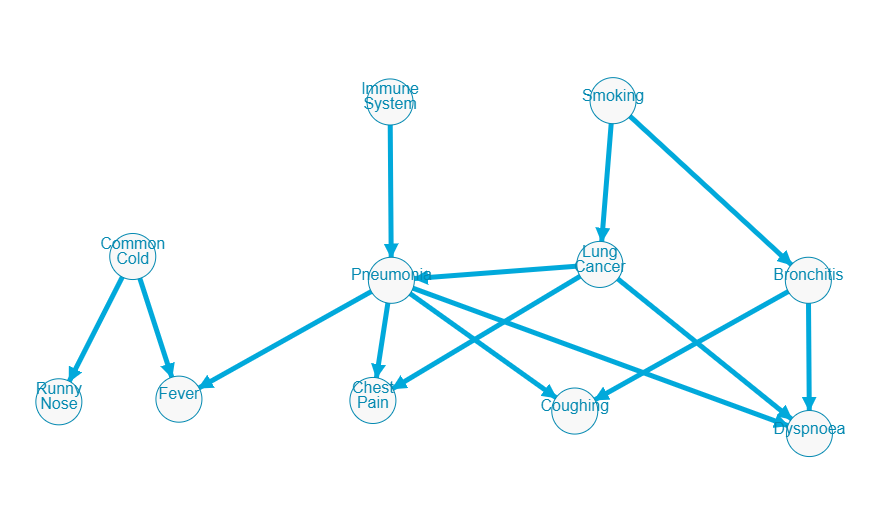

In [2]:
Image('bayesian_network.png')

Now, we will create a bayesian model according to the above mentioned specifications using pgmpy library. We have to use BayesianModel and specify all the nodes which are connected in the form of tuples.

In [3]:
model = BayesianModel([
                              ('Immune System', 'Pneumonia'), 
                              ('Smoking', 'Lung Cancer'),
                              ('Smoking', 'Bronchitis'),
                              ('Lung Cancer', 'Pneumonia'),
                              ('Common Cold', 'Fever'),
                              ('Common Cold', 'Runny Nose'),
                              ('Pneumonia', 'Fever'),
                              ('Pneumonia', 'Chest Pain'),
                              ('Pneumonia', 'Coughing'),
                              ('Pneumonia', 'Dyspnoea'),
                              ('Lung Cancer', 'Chest Pain'),
                              ('Lung Cancer', 'Dyspnoea'),
                              ('Bronchitis', 'Coughing'),
                              ('Bronchitis', 'Dyspnoea'),
                             ])

The next step is the quantitative part, i.e., the determination of the conditional probability tables. The numbers that we enter are rather arbitrary guesses and we do not pretend them to be anyhow realistic. In determining the conditional probabilities, we used some modeling assumptions such as that the probability of a symptom in the presence of an additional causing diseases is at least as high as the probability of that symptom in the absence of that disease. 
We will use TabularCPDs to define CPDs for all the nodes specifying names of the states.

In [4]:
# Defining individual CPDs.
cpd_immune_system = TabularCPD(variable='Immune System', variable_card=2, values=[[0.05],[0.95]], state_names={'Immune System': ['Weak', 'Strong']})
cpd_smoking = TabularCPD(variable='Smoking', variable_card=2, values=[[0.3], [0.7]], state_names={'Smoking': ['Smoker', 'Non-Smoker']})
cpd_common_cold = TabularCPD(variable='Common Cold', variable_card=2, values=[[0.35], [0.65]], state_names={'Common Cold': ['Sick', 'Healthy']})

cpd_lung_cancer = TabularCPD(variable='Lung Cancer', variable_card=2, 
                   values=[[0.1, 0.01],
                           [0.9, 0.99]
                          ],
                  evidence=['Smoking'],
                  evidence_card=[2],
                  state_names={'Lung Cancer': ['Sick', 'Healthy'],
                               'Smoking': ['Smoker', 'Non-Smoker']})

cpd_bronchitis = TabularCPD(variable='Bronchitis', variable_card=2, 
                   values=[[0.3, 0.01],
                           [0.7, 0.99]
                          ],
                  evidence=['Smoking'],
                  evidence_card=[2],
                  state_names={'Bronchitis': ['Sick', 'Healthy'],
                               'Smoking': ['Smoker', 'Non-Smoker']})

cpd_runny_nose = TabularCPD(variable='Runny Nose', variable_card=2, 
                   values=[[0.9, 0.01],
                           [0.1, 0.99]
                          ],
                  evidence=['Common Cold'],
                  evidence_card=[2],
                  state_names={'Runny Nose': ['Sick', 'Healthy'],
                               'Common Cold': ['Sick', 'Healthy']})

cpd_pneumonia = TabularCPD(variable='Pneumonia', variable_card=2, 
                   values=[[0.3, 0.3, 0.05,  0.001],
                           [0.7, 0.7, 0.95, 0.999]
                          ],
                  evidence=['Immune System', 'Lung Cancer'],
                  evidence_card=[2, 2],
                  state_names={'Pneumonia': ['Sick', 'Healthy'],
                               'Immune System': ['Weak', 'Strong'],
                               'Lung Cancer': ['Sick', 'Healthy']})

cpd_fever = TabularCPD(variable='Fever', variable_card=2, 
                   values=[[0.9, 0.9, 0.2,  0.01],
                           [0.1, 0.1, 0.8, 0.99]
                          ],
                  evidence=['Pneumonia', 'Common Cold'],
                  evidence_card=[2, 2],
                  state_names={'Fever': ['Sick', 'Healthy'],
                               'Pneumonia': ['Sick', 'Healthy'],
                               'Common Cold': ['Sick', 'Healthy']})

cpd_coughing = TabularCPD(variable='Coughing', variable_card=2, 
                   values=[[0.9, 0.9, 0.9,  0.1],
                           [0.1, 0.1, 0.1, 0.9]
                          ],
                  evidence=['Pneumonia', 'Bronchitis'],
                  evidence_card=[2, 2],
                  state_names={'Coughing': ['Sick', 'Healthy'],
                               'Pneumonia': ['Sick', 'Healthy'],
                               'Bronchitis': ['Sick', 'Healthy']})

cpd_chest_pain = TabularCPD(variable='Chest Pain', variable_card=2, 
                   values=[[0.9, 0.9, 0.9,  0.1],
                           [0.1, 0.1, 0.1, 0.9]
                          ],
                  evidence=['Pneumonia', 'Lung Cancer'],
                  evidence_card=[2, 2],
                  state_names={'Chest Pain': ['Sick', 'Healthy'],
                               'Pneumonia': ['Sick', 'Healthy'],
                               'Lung Cancer': ['Sick', 'Healthy']})

cpd_dyspnoea = TabularCPD(variable='Dyspnoea', variable_card=2, 
                   values=[[0.8, 0.8, 0.8,  0.8, 0.5, 0.5, 0.5,  0.1],
                           [0.2, 0.2, 0.2,  0.2, 0.5, 0.5, 0.5,  0.9]
                          ],
                  evidence=['Bronchitis', 'Lung Cancer','Pneumonia'],
                  evidence_card=[2, 2, 2],
                  state_names={'Dyspnoea': ['Sick', 'Healthy'],
                               'Bronchitis': ['Sick', 'Healthy'],
                               'Lung Cancer': ['Sick', 'Healthy'],
                               'Pneumonia': ['Sick', 'Healthy']})



Now, we will associate CPDs with the network and use check_model to check for the model structure and the associated CPD and returns True if everything is correct otherwise throws an exception

In [5]:
# Associating the CPDs with the network
model.add_cpds(cpd_immune_system, cpd_smoking, cpd_common_cold, cpd_lung_cancer, cpd_bronchitis, cpd_runny_nose, cpd_pneumonia, cpd_fever, cpd_coughing, cpd_chest_pain, cpd_dyspnoea)
model.check_model()

True

Now we will use some basic methods and queries exploring the pgmpy library

In [6]:
# We can now call some methods on the BayesianModel object.
model.get_cpds()

[<TabularCPD representing P(Immune System:2) at 0x16404e994e0>,
 <TabularCPD representing P(Smoking:2) at 0x16404e994a8>,
 <TabularCPD representing P(Common Cold:2) at 0x16404e99518>,
 <TabularCPD representing P(Lung Cancer:2 | Smoking:2) at 0x16404e99550>,
 <TabularCPD representing P(Bronchitis:2 | Smoking:2) at 0x16404e7a470>,
 <TabularCPD representing P(Runny Nose:2 | Common Cold:2) at 0x164793a9550>,
 <TabularCPD representing P(Pneumonia:2 | Immune System:2, Lung Cancer:2) at 0x16404e995c0>,
 <TabularCPD representing P(Fever:2 | Pneumonia:2, Common Cold:2) at 0x16404e99588>,
 <TabularCPD representing P(Coughing:2 | Pneumonia:2, Bronchitis:2) at 0x16404e995f8>,
 <TabularCPD representing P(Chest Pain:2 | Pneumonia:2, Lung Cancer:2) at 0x16404e99630>,
 <TabularCPD representing P(Dyspnoea:2 | Bronchitis:2, Lung Cancer:2, Pneumonia:2) at 0x16404e99668>]

In [7]:
# Printing a CPD using two different methods.
print(cpd_fever)
print(model.get_cpds('Fever'))

+----------------+-------------------+----------------------+--------------------+----------------------+
| Pneumonia      | Pneumonia(Sick)   | Pneumonia(Sick)      | Pneumonia(Healthy) | Pneumonia(Healthy)   |
+----------------+-------------------+----------------------+--------------------+----------------------+
| Common Cold    | Common Cold(Sick) | Common Cold(Healthy) | Common Cold(Sick)  | Common Cold(Healthy) |
+----------------+-------------------+----------------------+--------------------+----------------------+
| Fever(Sick)    | 0.9               | 0.9                  | 0.2                | 0.01                 |
+----------------+-------------------+----------------------+--------------------+----------------------+
| Fever(Healthy) | 0.1               | 0.1                  | 0.8                | 0.99                 |
+----------------+-------------------+----------------------+--------------------+----------------------+
+----------------+-------------------+--------

In [8]:
#Checking Cardinality of a Node
model.get_cardinality('Dyspnoea')

2

In [9]:
#Getting Children of a Node
model.get_children('Pneumonia')

['Fever', 'Chest Pain', 'Coughing', 'Dyspnoea']

In [10]:
#Getting Parents of a Node
model.get_parents('Pneumonia')

['Immune System', 'Lung Cancer']

In [11]:
#Getting predecessors of a node
list(model.predecessors("Fever"))

['Common Cold', 'Pneumonia']

In [12]:
#Getting successors of a node
list(model.successors("Smoking"))

['Lung Cancer', 'Bronchitis']

In [13]:
#Getting the list of leaves of our network
model.get_leaves()

['Fever', 'Runny Nose', 'Chest Pain', 'Coughing', 'Dyspnoea']

In [14]:
#Getting the list of roots of our network
model.get_roots()

['Immune System', 'Smoking', 'Common Cold']

In [15]:
#Getting the number of nodes of our network
model.number_of_nodes()

11

In [16]:
""" Getting markov blanket of a node. In the case of Bayesian Networks, the markov blanket is the set of node’s parents, 
its children and its children’s other parents. """
model.get_markov_blanket('Pneumonia')

['Chest Pain',
 'Coughing',
 'Immune System',
 'Fever',
 'Lung Cancer',
 'Dyspnoea',
 'Common Cold',
 'Bronchitis']

In [17]:
# Getting the local independencies of a variable.
model.local_independencies('Dyspnoea')

(Dyspnoea _|_ Chest Pain, Common Cold, Smoking, Coughing, Immune System, Runny Nose, Fever | Lung Cancer, Pneumonia, Bronchitis)

In [18]:
# Getting all the local independencies in the network.
model.local_independencies(['Immune System', 'Smoking', 'Common Cold', 'Lung Cancer',
                            'Bronchitis', 'Runny Nose', 'Pneumonia','Fever',
                            'Coughing','Chest Pain', 'Dyspnoea'])

(Immune System _|_ Lung Cancer, Bronchitis, Common Cold, Smoking, Runny Nose)
(Smoking _|_ Immune System, Runny Nose, Common Cold)
(Common Cold _|_ Chest Pain, Coughing, Immune System, Smoking, Lung Cancer, Pneumonia, Dyspnoea, Bronchitis)
(Lung Cancer _|_ Immune System, Bronchitis, Runny Nose, Common Cold | Smoking)
(Bronchitis _|_ Lung Cancer, Chest Pain, Pneumonia, Common Cold, Immune System, Runny Nose, Fever | Smoking)
(Runny Nose _|_ Chest Pain, Coughing, Immune System, Smoking, Fever, Lung Cancer, Pneumonia, Dyspnoea, Bronchitis | Common Cold)
(Pneumonia _|_ Smoking, Runny Nose, Bronchitis, Common Cold | Lung Cancer, Immune System)
(Fever _|_ Chest Pain, Runny Nose, Coughing, Immune System, Smoking, Lung Cancer, Dyspnoea, Bronchitis | Pneumonia, Common Cold)
(Coughing _|_ Chest Pain, Immune System, Smoking, Fever, Lung Cancer, Dyspnoea, Common Cold, Runny Nose | Pneumonia, Bronchitis)
(Chest Pain _|_ Runny Nose, Coughing, Immune System, Smoking, Fever, Dyspnoea, Common Cold, Bro

In [19]:
#Get all the independences
model.get_independencies()

(Immune System _|_ Lung Cancer, Runny Nose, Common Cold, Smoking, Bronchitis)
(Immune System _|_ Runny Nose, Common Cold | Chest Pain)
(Immune System _|_ Lung Cancer, Smoking, Bronchitis, Common Cold | Runny Nose)
(Immune System _|_ Runny Nose, Common Cold | Coughing)
(Immune System _|_ Lung Cancer, Runny Nose, Bronchitis, Common Cold | Smoking)
(Immune System _|_ Smoking, Runny Nose, Bronchitis, Common Cold | Lung Cancer)
(Immune System _|_ Runny Nose, Fever, Common Cold | Pneumonia)
(Immune System _|_ Runny Nose, Common Cold | Dyspnoea)
(Immune System _|_ Lung Cancer, Smoking, Runny Nose, Bronchitis | Common Cold)
(Immune System _|_ Lung Cancer, Smoking, Runny Nose, Common Cold | Bronchitis)
(Immune System _|_ Common Cold | Chest Pain, Runny Nose)
(Immune System _|_ Runny Nose, Common Cold | Coughing, Chest Pain)
(Immune System _|_ Runny Nose, Bronchitis, Common Cold | Chest Pain, Smoking)
(Immune System _|_ Smoking, Runny Nose, Bronchitis, Common Cold | Lung Cancer, Chest Pain)
(Imm

In [20]:
# Active trail: For any two variables A and B in a network if any change in A influences the values of B then we say
#               that there is an active trail between A and B.
# In pgmpy active_trail_nodes gives a set of nodes which are affected (i.e. correlated) by any 
# change in the node passed in the argument.
model.active_trail_nodes('Dyspnoea')

{'Dyspnoea': {'Bronchitis',
  'Chest Pain',
  'Coughing',
  'Dyspnoea',
  'Fever',
  'Immune System',
  'Lung Cancer',
  'Pneumonia',
  'Smoking'}}

In [21]:
#Active trails vary according to the observed variables
model.active_trail_nodes('Dyspnoea', observed='Pneumonia')

{'Dyspnoea': {'Bronchitis',
  'Chest Pain',
  'Coughing',
  'Dyspnoea',
  'Immune System',
  'Lung Cancer',
  'Smoking'}}

Exploring the common evidence trail phenomenon
Common Evidence: This case is a bit different from the other connections of nodes. This happens when two differnt nodes have the same children. They are independant when the child is not observed. Whereas when the child is observed, there is an active trail in between them. This structure is also commonly known as V structure.

In [22]:
# Pneumonia and Common Cold have common child Fever, they are independant initially
model.is_active_trail('Pneumonia', 'Common Cold')

False

In [23]:
# As soon as their child "Fever" is observed, they get dependent on each other
model.is_active_trail('Pneumonia', 'Common Cold', observed=['Fever'])

True

## Reasoning:
Now that the model is defined, we can use it for reasoning, e.g. by entering observational evidence into the system and doing inference, i.e. computing conditional probabilities given this evidence. To do the computation, we have modeled the system utilizing variable elimination methodology. The marginal node probabilities are the probability distributions of each of the variables in the absence of any additional evidence. In the program, evidence can be entered by specifying as an evidence of the variable in a query. This procedure is sometimes called ‘clamping’. The node probabilities will then be conditioned on the clamped evidence. 

In [24]:
#Specifying the variable elimination method for inference
infer = VariableElimination(model)


In [25]:
#Infering marginal probability of a node
print(infer.query(['Pneumonia']))

Eliminating: Runny Nose: 100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.10it/s]


+--------------------+------------------+
| Pneumonia          |   phi(Pneumonia) |
+====================+==================+
| Pneumonia(Sick)    |           0.0177 |
+--------------------+------------------+
| Pneumonia(Healthy) |           0.9823 |
+--------------------+------------------+


In [26]:
#Sometimes, we are only interested in the state, not the probabilities so we use map_query method
print(infer.map_query(['Dyspnoea']))

Eliminating: Runny Nose: 100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.15it/s]


{'Dyspnoea': 'Healthy'}


### Knowledge representation:
Bayesian networks may serve as a rich knowledge base. This is illustrated by considering a number of hypothetical medical guidelines and comparing these with Bayesian network inference results. These results will also serve to comment on some of the typical behavior in Bayesian networks.
1. In case of high fever in absence of a runny nose, one should consider pneumonia.
#### Inference: 
We clamp fever = sick and runny nose = healthy and look at the conditional probabilities of the four diseases. We see that in particular the probability of pneumonia is increased from about 2% to 45%


In [27]:
print(infer.query(['Pneumonia']))
print(infer.query(['Pneumonia'], evidence={'Fever': 'Sick', 'Runny Nose': 'Healthy'}))

Eliminating: Runny Nose: 100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.05it/s]


+--------------------+------------------+
| Pneumonia          |   phi(Pneumonia) |
+====================+==================+
| Pneumonia(Sick)    |           0.0177 |
+--------------------+------------------+
| Pneumonia(Healthy) |           0.9823 |
+--------------------+------------------+


Eliminating: Common Cold: 100%|█████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 511.95it/s]


+--------------------+------------------+
| Pneumonia          |   phi(Pneumonia) |
+====================+==================+
| Pneumonia(Sick)    |           0.4499 |
+--------------------+------------------+
| Pneumonia(Healthy) |           0.5501 |
+--------------------+------------------+


#### Comment: 
There are two causes in the model for fever, namely has parents pneumonia and common cold. However, the absence of a common cold makes common cold less likely. This makes the other explaining cause pneumonia more likely.

2. Lung cancer is often found in patients with chest pain, dyspnoea, no fever, and usually no wet coughing. 
#### Inference: 
We clamp chest pain = sick, dyspnoea = sick, fever = healthy, and coughing = healthy. We see that probability of lung cancer is raised 0.57. Even if we set coughing = sick, the probability is still as high as 0.47.

In [28]:
print(infer.query(['Lung Cancer']))
print(infer.query(['Lung Cancer'], evidence={'Chest Pain': 'Sick', 'Fever': 'Healthy', 'Dyspnoea': 'Sick', 'Coughing': 'Healthy'}))
print(infer.query(['Lung Cancer'], evidence={'Chest Pain': 'Sick', 'Fever': 'Healthy', 'Dyspnoea': 'Sick', 'Coughing': 'Sick'}))

Eliminating: Runny Nose: 100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.07it/s]


+----------------------+--------------------+
| Lung Cancer          |   phi(Lung Cancer) |
+======================+====================+
| Lung Cancer(Sick)    |             0.0370 |
+----------------------+--------------------+
| Lung Cancer(Healthy) |             0.9630 |
+----------------------+--------------------+


Eliminating: Pneumonia: 100%|████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]


+----------------------+--------------------+
| Lung Cancer          |   phi(Lung Cancer) |
+======================+====================+
| Lung Cancer(Sick)    |             0.5686 |
+----------------------+--------------------+
| Lung Cancer(Healthy) |             0.4314 |
+----------------------+--------------------+


Eliminating: Pneumonia: 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 384.09it/s]


+----------------------+--------------------+
| Lung Cancer          |   phi(Lung Cancer) |
+======================+====================+
| Lung Cancer(Sick)    |             0.4659 |
+----------------------+--------------------+
| Lung Cancer(Healthy) |             0.5341 |
+----------------------+--------------------+


#### Comment: 
Chest pain and dyspnoea can both be caused by lung cancer. However, chest pain for example, can also be caused by pneumonia. The absence of in particular fever makes pneumonia less likely and therefore lung cancer more likely. To a lesser extend this holds for absence of coughing and bronchitis.

3. Bronchitis and lung cancer are often accompanied, e.g patients with bronchitis often develop a lung cancer or vice versa.  owever, these diseases have no known causal relation, i.e., bronchitis is not a cause of lung cancer, and lung cancer is not a cause of bronchitis.
#### Inference: 
According to the model, P(lung cancer|bronchitis = sick) = 0.09 and P(bronchitis|lung cancer = sick) = 0.25. Both probabilities are more than twice the marginal probabilities.

In [29]:
print(infer.query(['Lung Cancer']))
print(infer.query(['Bronchitis']))
print(infer.query(['Lung Cancer'], evidence={'Bronchitis': 'Sick'}))
print(infer.query(['Bronchitis'], evidence={'Lung Cancer': 'Sick'}))
print(infer.query(['Lung Cancer'], evidence={'Bronchitis': 'Sick', 'Smoking':'Smoker'}))
print(infer.query(['Bronchitis'], evidence={'Lung Cancer': 'Sick', 'Smoking':'Smoker'}))

Eliminating: Runny Nose: 100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 640.11it/s]


+----------------------+--------------------+
| Lung Cancer          |   phi(Lung Cancer) |
+======================+====================+
| Lung Cancer(Sick)    |             0.0370 |
+----------------------+--------------------+
| Lung Cancer(Healthy) |             0.9630 |
+----------------------+--------------------+


Eliminating: Runny Nose: 100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 320.07it/s]


+---------------------+-------------------+
| Bronchitis          |   phi(Bronchitis) |
+=====================+===================+
| Bronchitis(Sick)    |            0.0970 |
+---------------------+-------------------+
| Bronchitis(Healthy) |            0.9030 |
+---------------------+-------------------+


Eliminating: Smoking: 100%|█████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 576.07it/s]


+----------------------+--------------------+
| Lung Cancer          |   phi(Lung Cancer) |
+======================+====================+
| Lung Cancer(Sick)    |             0.0935 |
+----------------------+--------------------+
| Lung Cancer(Healthy) |             0.9065 |
+----------------------+--------------------+


Eliminating: Smoking: 100%|█████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 576.11it/s]


+---------------------+-------------------+
| Bronchitis          |   phi(Bronchitis) |
+=====================+===================+
| Bronchitis(Sick)    |            0.2451 |
+---------------------+-------------------+
| Bronchitis(Healthy) |            0.7549 |
+---------------------+-------------------+


Eliminating: Runny Nose: 100%|██████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 512.13it/s]


+----------------------+--------------------+
| Lung Cancer          |   phi(Lung Cancer) |
+======================+====================+
| Lung Cancer(Sick)    |             0.1000 |
+----------------------+--------------------+
| Lung Cancer(Healthy) |             0.9000 |
+----------------------+--------------------+


Eliminating: Runny Nose: 100%|██████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 511.96it/s]


+---------------------+-------------------+
| Bronchitis          |   phi(Bronchitis) |
+=====================+===================+
| Bronchitis(Sick)    |            0.3000 |
+---------------------+-------------------+
| Bronchitis(Healthy) |            0.7000 |
+---------------------+-------------------+


#### Comment: 
Both diseases have the same common cause: smoking. If the state of smoking is observed, the correlation is broken.

### Diagnostic reasoning
We can apply the system for diagnosis. the idea is to enter the patient observations, i.e. symptoms and risk factors into the system. Then diagnosis (i.e. finding the cause(s) of the symptoms) is done by Bayesian inference. In the following, we present some hypothetical cases, present the inference results and comment on the reasoning by the network.

1. Mr. Appelflap calls. He lives with his wife and two children in a nice little house in the suburb. You know him well and you have good reasons to assume that he has no risk of a weakened immune system. Mr. Appelflap complains about high fever and a nasty wet cough (although he is a non-smoker). In addition, he sounds rather nasal. What is the diagnosis?

#### Inference: 
We clamp the risk factors immune system = strong, smoking = non-smoker and the symptoms fever = sick, runny nose = sick, coughing: sick. 


In [30]:
print(infer.query(['Common Cold'],evidence={'Immune System': 'Strong', 'Smoking':'Non-Smoker','Fever': 'Sick', 'Runny Nose' : 'Sick', 'Coughing':'Sick'}))
print(infer.query(['Lung Cancer'], evidence={'Immune System': 'Strong', 'Smoking':'Non-Smoker','Fever': 'Sick', 'Runny Nose' : 'Sick', 'Coughing':'Sick'}))
print(infer.query(['Bronchitis'], evidence={'Immune System': 'Strong', 'Smoking':'Non-Smoker','Fever': 'Sick', 'Runny Nose' : 'Sick', 'Coughing':'Sick'}))
print(infer.query(['Pneumonia'], evidence={'Immune System': 'Strong', 'Smoking':'Non-Smoker','Fever': 'Sick', 'Runny Nose' : 'Sick', 'Coughing':'Sick'}))
print(infer.query(['Common Cold','Lung Cancer','Bronchitis', 'Pneumonia'], 
                  evidence={'Immune System': 'Strong', 'Smoking':'Non-Smoker','Fever': 'Sick', 'Runny Nose' : 'Sick', 'Coughing':'Sick'}))

Eliminating: Pneumonia: 100%|████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


+----------------------+--------------------+
| Common Cold          |   phi(Common Cold) |
+======================+====================+
| Common Cold(Sick)    |             0.9979 |
+----------------------+--------------------+
| Common Cold(Healthy) |             0.0021 |
+----------------------+--------------------+


Eliminating: Common Cold: 100%|██████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


+----------------------+--------------------+
| Lung Cancer          |   phi(Lung Cancer) |
+======================+====================+
| Lung Cancer(Sick)    |             0.0271 |
+----------------------+--------------------+
| Lung Cancer(Healthy) |             0.9729 |
+----------------------+--------------------+


Eliminating: Common Cold: 100%|█████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 320.11it/s]


+---------------------+-------------------+
| Bronchitis          |   phi(Bronchitis) |
+=====================+===================+
| Bronchitis(Sick)    |            0.0794 |
+---------------------+-------------------+
| Bronchitis(Healthy) |            0.9206 |
+---------------------+-------------------+


Eliminating: Common Cold: 100%|█████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 320.07it/s]


+--------------------+------------------+
| Pneumonia          |   phi(Pneumonia) |
+====================+==================+
| Pneumonia(Sick)    |           0.0540 |
+--------------------+------------------+
| Pneumonia(Healthy) |           0.9460 |
+--------------------+------------------+


Eliminating: Dyspnoea: 100%|█████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


+----------------------+--------------------+---------------------+----------------------+-----------------------------------------------------+
| Common Cold          | Pneumonia          | Bronchitis          | Lung Cancer          |   phi(Common Cold,Pneumonia,Bronchitis,Lung Cancer) |
+======================+====================+=====================+======================+=====================================================+
| Common Cold(Sick)    | Pneumonia(Sick)    | Bronchitis(Sick)    | Lung Cancer(Sick)    |                                              0.0002 |
+----------------------+--------------------+---------------------+----------------------+-----------------------------------------------------+
| Common Cold(Sick)    | Pneumonia(Sick)    | Bronchitis(Sick)    | Lung Cancer(Healthy) |                                              0.0004 |
+----------------------+--------------------+---------------------+----------------------+----------------------------------------

We find all disease probabilities very small, except common cold, which is almost certainly true.
#### Comment: 
Due to the absence of risk factors, the prior probabilities of the other diseases that could explain the symptoms is very small compared to the prior probability of common cold. Since common cold also explains all the symptoms, that disease takes all the probability of the other causes. This phenomenon is called ’explaining away’: pattern of reasoning in which the confirmation of one cause (common cold, with a high prior probability and confirmed by runny nose ) of an observed event (fever) reduces the need to invoke alternative causes (pneumonia as an explanation of fever).

2. The salvation army calls. An unknown person (looking not very well) has arrived in their shelter for homeless people. This person has high fever, a nasty wet cough (and a runny nose.) What is the diagnosis?
#### Inference: 
We suspect a weakened immune system, so the system we clamp the risk factor immune system = weak. As in the previous case, the symptoms are fever = sick, runnynose = sick, coughing: sick.

In [31]:
print(infer.query(['Common Cold'],evidence={'Immune System': 'Weak','Fever': 'Sick', 'Runny Nose' : 'Sick', 'Coughing':'Sick'}))
print(infer.query(['Lung Cancer'], evidence={'Immune System': 'Weak','Fever': 'Sick', 'Runny Nose' : 'Sick', 'Coughing':'Sick'}))
print(infer.query(['Bronchitis'], evidence={'Immune System': 'Weak','Fever': 'Sick', 'Runny Nose' : 'Sick', 'Coughing':'Sick'}))
print(infer.query(['Pneumonia'], evidence={'Immune System': 'Weak','Fever': 'Sick', 'Runny Nose' : 'Sick', 'Coughing':'Sick'}))
print(infer.query(['Common Cold','Lung Cancer','Bronchitis', 'Pneumonia'], 
                  evidence={'Immune System': 'Weak','Fever': 'Sick', 'Runny Nose' : 'Sick', 'Coughing':'Sick'}))

Eliminating: Pneumonia: 100%|███████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 384.10it/s]


+----------------------+--------------------+
| Common Cold          |   phi(Common Cold) |
+======================+====================+
| Common Cold(Sick)    |             0.9815 |
+----------------------+--------------------+
| Common Cold(Healthy) |             0.0185 |
+----------------------+--------------------+


Eliminating: Common Cold: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 922.10it/s]


+----------------------+--------------------+
| Lung Cancer          |   phi(Lung Cancer) |
+======================+====================+
| Lung Cancer(Sick)    |             0.0393 |
+----------------------+--------------------+
| Lung Cancer(Healthy) |             0.9607 |
+----------------------+--------------------+


Eliminating: Common Cold: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 384.14it/s]


+---------------------+-------------------+
| Bronchitis          |   phi(Bronchitis) |
+=====================+===================+
| Bronchitis(Sick)    |            0.1330 |
+---------------------+-------------------+
| Bronchitis(Healthy) |            0.8670 |
+---------------------+-------------------+


Eliminating: Common Cold: 100%|█████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 384.13it/s]


+--------------------+------------------+
| Pneumonia          |   phi(Pneumonia) |
+====================+==================+
| Pneumonia(Sick)    |           0.9088 |
+--------------------+------------------+
| Pneumonia(Healthy) |           0.0912 |
+--------------------+------------------+


Eliminating: Smoking: 100%|█████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 191.98it/s]


+--------------------+----------------------+----------------------+---------------------+-----------------------------------------------------+
| Pneumonia          | Lung Cancer          | Common Cold          | Bronchitis          |   phi(Pneumonia,Lung Cancer,Common Cold,Bronchitis) |
+====================+======================+======================+=====================+=====================================================+
| Pneumonia(Sick)    | Lung Cancer(Sick)    | Common Cold(Sick)    | Bronchitis(Sick)    |                                              0.0081 |
+--------------------+----------------------+----------------------+---------------------+-----------------------------------------------------+
| Pneumonia(Sick)    | Lung Cancer(Sick)    | Common Cold(Sick)    | Bronchitis(Healthy) |                                              0.0249 |
+--------------------+----------------------+----------------------+---------------------+----------------------------------------

However, now we not only find common cold with a high probability (P = 0.98), but also pneumonia (P = 0.91). 
#### Comment: 
Due to the fact that with a weakened immune system, the prior probability of pneumonia is almost as high as the prior probability of common cold. Therefore the conclusion is very different from the previous case. Note that for this diagnosis, it is important that diseases can co-occur in the model.

3. A patient suffers from a recurrent pneumonia. This patient is a heavy smoker but otherwise leads a ‘normal’, healthy live, so you may assume there is no risk of a weakened immune system. What is your advice? 
#### Inference: 
We clamp immune system = strong, smoking = non-smoker, and pneumonia = sick.

In [32]:
print(infer.query(['Common Cold'],evidence={'Immune System': 'Strong','Smoking': 'Smoker','Pneumonia': 'Sick'}))
print(infer.query(['Lung Cancer'], evidence={'Immune System': 'Strong','Smoking': 'Smoker','Pneumonia': 'Sick'}))
print(infer.query(['Bronchitis'], evidence={'Immune System': 'Strong','Smoking': 'Smoker','Pneumonia': 'Sick'}))
print(infer.query(['Common Cold','Lung Cancer','Bronchitis'], 
                  evidence={'Immune System': 'Strong','Smoking': 'Smoker','Pneumonia': 'Sick'}))

Eliminating: Fever: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 448.11it/s]


+----------------------+--------------------+
| Common Cold          |   phi(Common Cold) |
+======================+====================+
| Common Cold(Sick)    |             0.3500 |
+----------------------+--------------------+
| Common Cold(Healthy) |             0.6500 |
+----------------------+--------------------+


Eliminating: Fever: 100%|████████████████████████████████████████████████████████████████████████| 7/7 [00:00<?, ?it/s]


+----------------------+--------------------+
| Lung Cancer          |   phi(Lung Cancer) |
+======================+====================+
| Lung Cancer(Sick)    |             0.8475 |
+----------------------+--------------------+
| Lung Cancer(Healthy) |             0.1525 |
+----------------------+--------------------+


Eliminating: Fever: 100%|███████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 448.10it/s]


+---------------------+-------------------+
| Bronchitis          |   phi(Bronchitis) |
+=====================+===================+
| Bronchitis(Sick)    |            0.3000 |
+---------------------+-------------------+
| Bronchitis(Healthy) |            0.7000 |
+---------------------+-------------------+


Eliminating: Fever: 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:00<?, ?it/s]


+---------------------+----------------------+----------------------+-------------------------------------------+
| Bronchitis          | Common Cold          | Lung Cancer          |   phi(Bronchitis,Common Cold,Lung Cancer) |
+=====================+======================+======================+===========================================+
| Bronchitis(Sick)    | Common Cold(Sick)    | Lung Cancer(Sick)    |                                    0.0890 |
+---------------------+----------------------+----------------------+-------------------------------------------+
| Bronchitis(Sick)    | Common Cold(Sick)    | Lung Cancer(Healthy) |                                    0.0160 |
+---------------------+----------------------+----------------------+-------------------------------------------+
| Bronchitis(Sick)    | Common Cold(Healthy) | Lung Cancer(Sick)    |                                    0.1653 |
+---------------------+----------------------+----------------------+-------------------

As a result, we see that there is a high probability of lung cancer. 
#### Comment: 
The reason is that due to smoking, the prior of disease is increased. More importantly, however, is that weakened immune system is excluded as cause of the pneumonia, so that lung cancer remains as the most likely explanation of the cause of the recurrent pneumonia.